# Text classification :: Overview

## Task 

We want to build a Spam detector which, given examples of spam emails (e.g. flagged by users) and examples of regular (non-spam, also called "ham") emails, learns how to flag new unseen emails as spam or non-spam.

## Data

We will use the [SpamAssassin](https://spamassassin.apache.org/) public email corpus. This dataset contains ~6'000 labeled emails with a ~30% spam ratio. If you want to learn more about this dataset, check [this](https://spamassassin.apache.org/old/publiccorpus/). (*Note: Datasets of text are called corpora and samples are called documents.*) 

The dataset has been downloaded for you and is available in the *data* folder.

## Notebook overview

* Load the data
* Text preprocessing
* Data exploration
* Feature extraction
* Build a spam detector
* What did our model learn? Error analysis

# Text classification :: Spam detection


## Load the data

In [2]:
# Load libraries and helper functions
import tools

In [3]:
# Load the data
df = tools.load_data()

Data loaded.
Data size: (5832, 2)


Let's check the number of samples per class in the data.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: label, dtype: float64




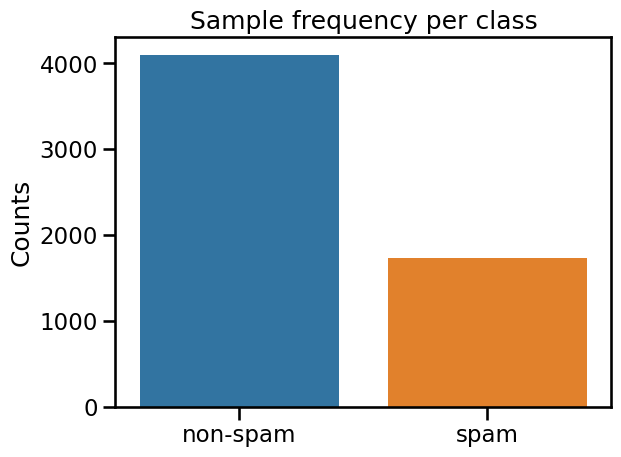

In [4]:
tools.plot_class_frequency(df)

Now, let's have a look at a few rows from the dataset.

***Note:*** The *label* is 0 for *non-spam* and 1 for *spam*.

In [5]:
# If you rerun this cell then you get a different set of samples displayed
df.sample(3)

,label,text
5130,0,"> From: fork-admin@xent.com [mailto:fork-admin@xent.com] On Behalf Of Justin > Mason > > So IMO it's the corruption that's the problem; and corruption != > regulation, and corruption != socialism. Also, over-population is really > a symptom of that. Socialism increases regulation which increases corruption. But that doesn't matter as much as if the official law does not conform to the facts on the ground. If you don't match the law to the facts on the ground, you wind up with a two-tier society (De Soto's Bell Jar). Worse, the massive evasion of the official law encourages the corruption you speak of. In some countries, the agencies in charge of registering property also arrange for illegal living arrangements for their employees. They do this because even the people who run the system can't make it work for people they care about. http://xent.com/mailman/listinfo/fork"
1146,1,"Note:If this eamil is not fit for you,please reply to webmaster@wjjzzs.com with ""remove"".You'd tell me the email address we've used. We don't intend to send spam email to you.Thank you! ATTN:fork@xent.com Dear sirs or Madams, We are one Arcyl bathtub manufacturer in China. -----------------Profile----------------------- Our factoryspecializes in manufacturing ¡°YEMA¡± brand acrylic composite bathtubs, we have more than 10 years experience of bathtub manufacturing and marketing. With our considerable experience we set out to blend the advantages of all the other of bathtubs offered in the market place into one range. After several years development we produced our current range and the YEMA brand bathtub was patented in 2001. We were even awarded the ""Gold Medal"" in the ""Chinese Patent Technology Exhibition"" and ""The Ninth Chinese New Patent Technology and New Patent Product Exhibition"" later that year. The YEMA bathtubs structural design is that of a normal acrylic bathtub but conglutinated into a composite material. It is ridged and is made more than twice as thick as a normal unit, making it more smooth, gentle and elegant. This manufacturing technique not only provides all the advantages of a normal acrylic bathtub (easily to clean, resistance to dirt, colorful,attractive etc) but also provides increased heat retention, and extends the products life span. Besides our products on website, we now produce some new models for USA market. We also produce shower panels with finest quality. -------------------bathtub Specifications--------------------- 1,Wall thickness:10mm~20mm 2,Weight: 50~60KG -------------------Cooperate-------------------------------- We would like to be your OEM/ODM manufacturer. For detailed info, please browse our website http://www.wjjzzs.com Best wishes and regards, Export Manager Jerry Lee Mobile:13951228561 Phone:0086-519-5211973 Fax: 0086-519-5209776 Wujin Huangli Composited Sanitary Factory Add:HUangli town,Wujin county Changzhou 21315..."
2402,0,http://www.post-gazette.com/columnists/20020905brian5.asp


## Text preprocessing

Good text preprocessing is an essential part of every NLP project!

Our goal here is to build a model that distinguishes non-spam from spam. The idea here is to "clean" and "standardize" raw text before feeding it to our machine learning model. We need to keep as many "informative" words as possible, while discarding the "uniformative" ones. Removing unnecessary content, i.e. the "noise", from our texts will help to improve the accuracy of our models.

## 💡 Observations

- There are some items in the text that should be removed to make it readable. Here are some suggestions:

* HTML tags 
* URLs
* E-mail addresses
* Punctuation marks, digits (e.g. 2002, 1.1, ...)
* Multiple whitespaces
* Case conversion (e.g. Dog vs dog, ...)
* English STOPWORDS (e.g. a, is, my, i, all, and, by...)
* ...

- It is likely that the number of occurrences of the above items (HTML tags, URLs, etc) is helpful to distinguish spam from non-spam. Similarly, the length of the emails and the frequency of punctuation marks or upper case letters may also give us clues as to whether we are dealing with spam or not.

The *clean_corpus* function below will take care of the parts raised in the 1st observation. For the ideas from the 2nd observation we will create new features and investigate their effects in the subsection **What about "spammish" signatures?**. 

In [6]:
df = tools.clean_corpus(df)

print("Data cleaned")

Data cleaned


Let's have a look at a few "cleaned" examples.

In [7]:
tools.show_clean_text(df)


Original document:

Albert White - SUN Ireland wrote: > Hi, > > Thanks for the replies. It turns out that it was an IRQ
conflict with an old > sound card. > > Despite checking the BIOS and running the 3c509 setup utility
on > http://www.scyld.com/diag, the 2.4 kernel still picked a card on IRQ 5 and 10. > > It works
fine now that the sound card is removed, but I'm still confused as to > why this worked in 2.2.18
but not 2.4.19, seems like a regression to me... I'm jumping in here since I'm just back on ILUG
after quite a long break, anyway... Alan Cox was mentioning that he might have borked some PNP stuff
lately. You could try 2.4.19-ac4 to see if it helps. Pádraig. -- Irish Linux Users' Group:
ilug@linux.ie http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information. List
maintainer: listmaster@linux.ie

Cleaned document:

albert white ireland wrote thanks replies turns conflict sound card despite checking bios running
setup utility kernel picked card works fine sound

## Data Exploration :: What makes spam distinct?

### Frequent words

Which words distinguish spam from non-spam? Can we  identify the words in a text that are the most informative about its topic?

Let's find the 10 most frequent words in spam and non-spam and compare them.

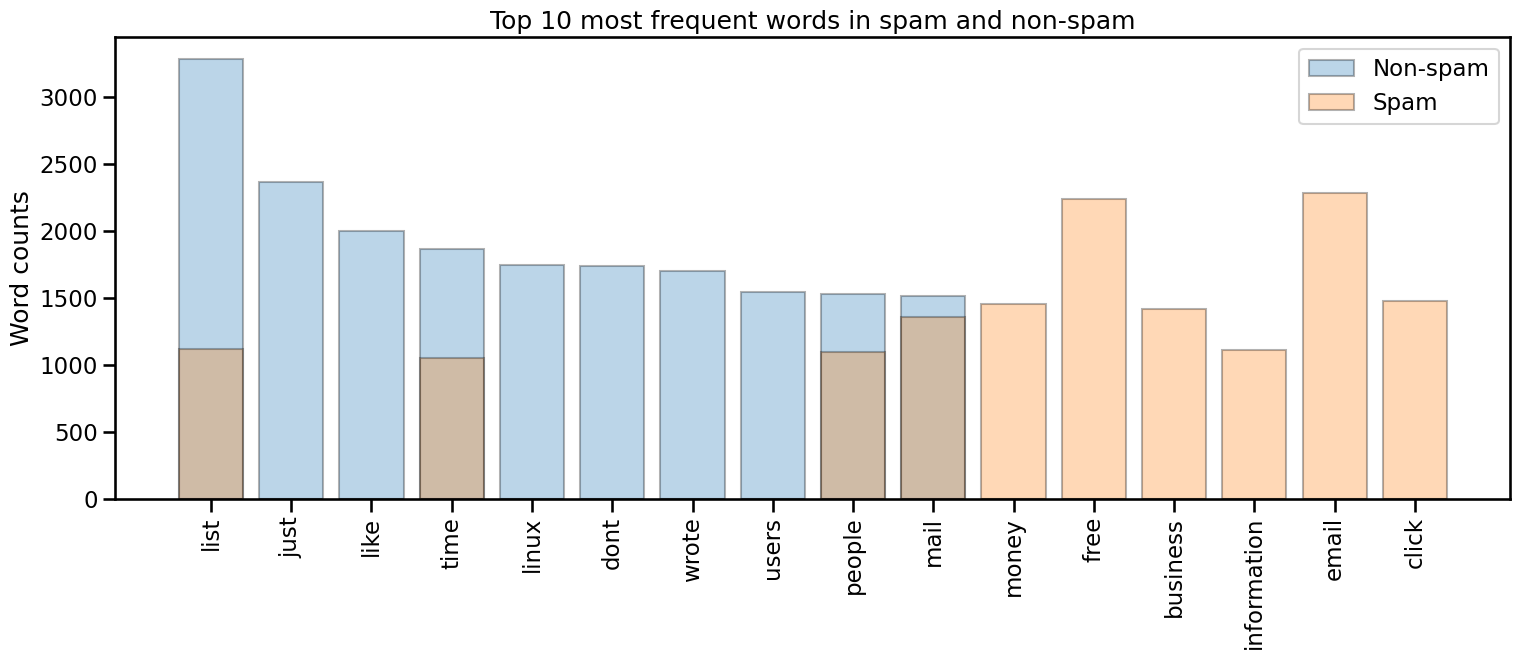

In [8]:
tools.plot_most_common_words(df=df, N=10)

## 💡 Observations

**Frequent "spammish" words**: 

* free
* email
* click
* business
* money

**Frequent "non-spammish" words**:

* just
* like
* linux
* wrote
* users  

**Occur in both top 10 but could be useful for distinctions**:

* list
* time

**Occur in both top 10 but are unlikely to be useful**:

* people
* mail

<div class="alert alert-success">
    
Let's change `N=10` to `N=30` and compare the outcome.
</div>

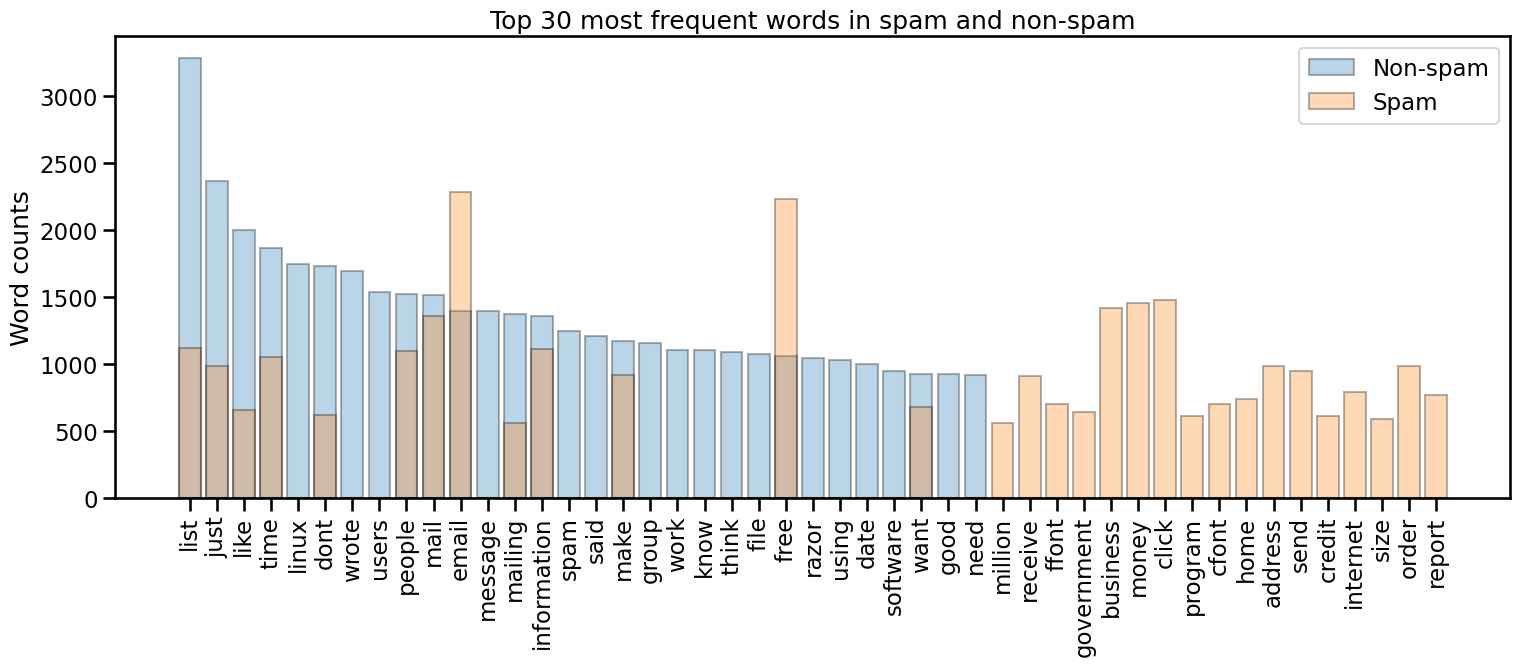

In [9]:
tools.plot_most_common_words(df=df, N=30)

## 💡 Observations

As we use more top words we get more overlap between the classes.  
However words like _email_ or _free_ are still mch more frequent in the **spam** class 

### What about "spammish" signatures?

* Do spams contain more HTML tags? 
* Does non-spam contain more URLs and E-mail adresses? 
* Are spams mails longer than non-spam? 
* ...

Let's find out!

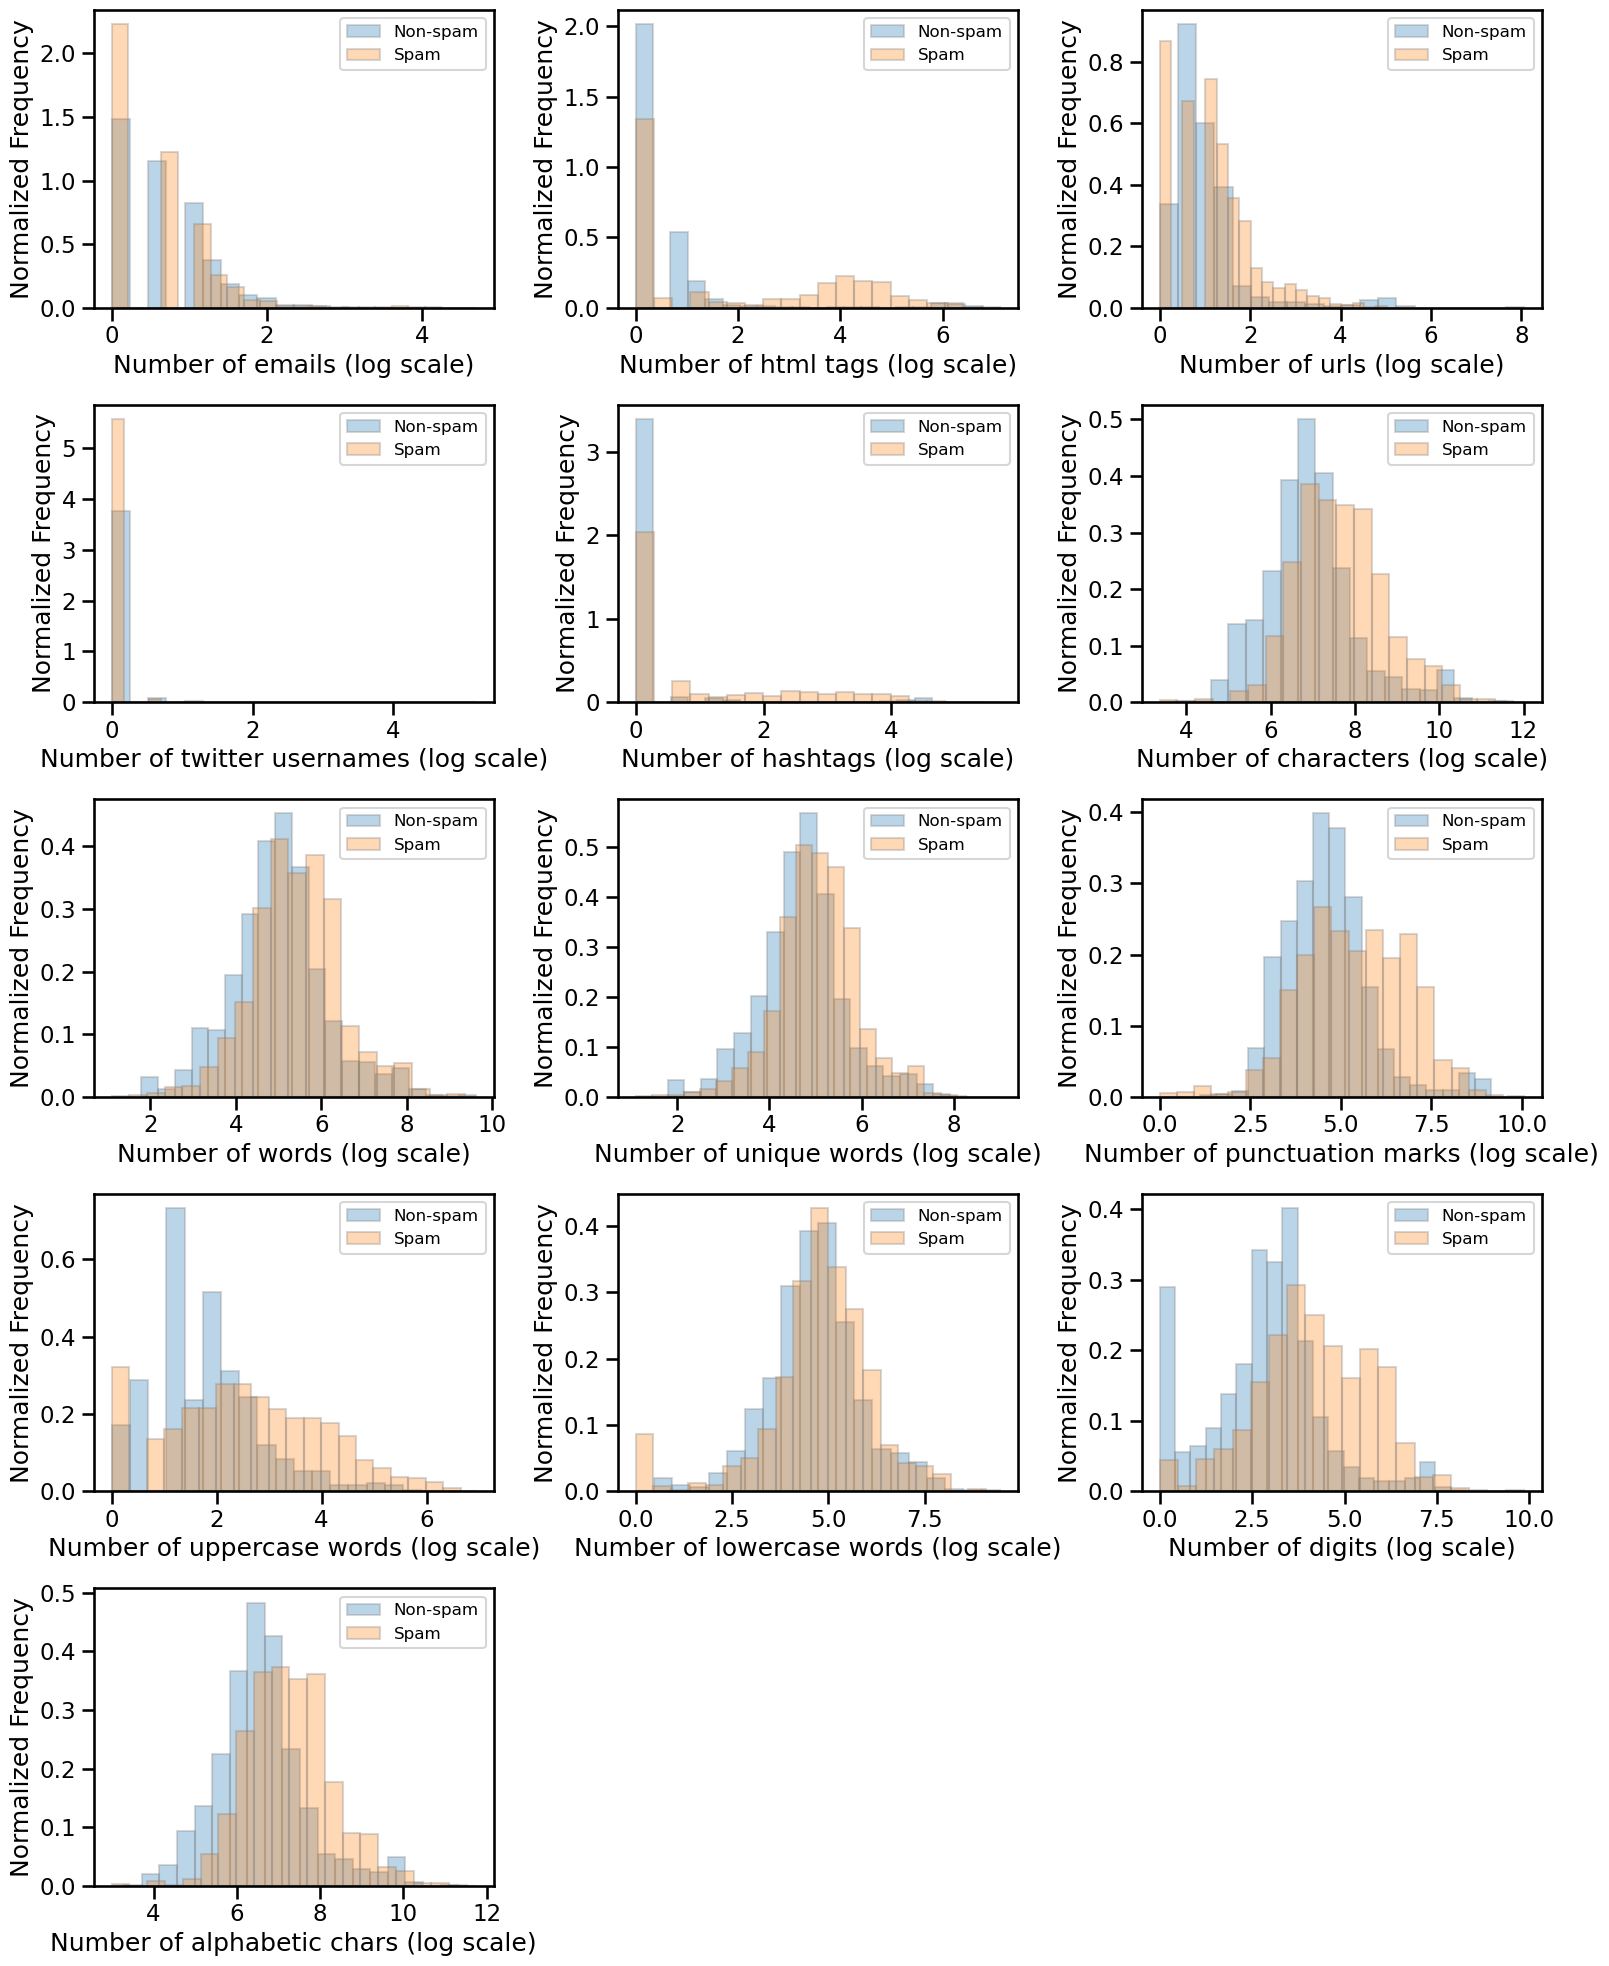

In [10]:
features = tools.get_features(df=df)

## Feature engineering :: Extracting features from text

Computers don't understand natural language. So, how do we represent text?

One of the simplest but effective and commonly used models to represent text for machine learning is the ***Bag of Words*** model ([online documentation](https://en.wikipedia.org/wiki/Bag-of-words_model)). When using this model, we discard most of the structure of the input text (word order, chapters, paragraphs, sentences and formating) and only count how often each word appears in each text. Discarding the structure and counting only word occurencies leads to the mental image of representing text as a "bag".  

**Example:** Let our toy corpus contain four documents.

$ corpus = ['I\;enjoy\;paragliding.',  $  
$\hspace{2cm}'I\;like\;NLP.',$  
$\hspace{2cm}'I\;like\;deep\;learning.',$  
$\hspace{2cm}'O\;Captain!\;my\;Captain!']$ 

In [11]:
tools.show_bag_of_words_vector()

,captain,deep,enjoy,i,learning,like,my,nlp,o,paragliding
Text,,,,,,,,,,
I enjoy paragliding.,0,0,1,1,0,0,0,0,0,1
I like NLP.,0,0,0,1,0,1,0,1,0,0
I like deep learning.,0,1,0,1,1,1,0,0,0,0
O Captain! my Captain!,2,0,0,0,0,0,1,0,1,0


Bag of Words has converted all documents into numeric vectors. Each column represents a word from the corpus and each row one of the four documents. The value in each cell represents the number of times that word appears in a specific document. For example, the fourth document has the word `captain` occuring twice and the words `my` and `O` occuring once.

## Build a spam detector

In the previous section, we saw how to perform text preprocessing and feature extraction from text. We are now ready to build our machine learning model for detecting spams. We will use a Logistic Regression classifier ([online documentation](https://en.wikipedia.org/wiki/Logistic_regression)).

First, split the data into two sets: the `train` set and the `test` set. We will then use the train set to `fit` our model. We will use 5-fold cross-validation. So the validation sets are automatically created internally. The test set will be used to `evaluate` the performance of our model. 

### Baseline

70.3% of samples are non-spam. This naive baseline model would reach 70+% for doing very little.

### Spam classification

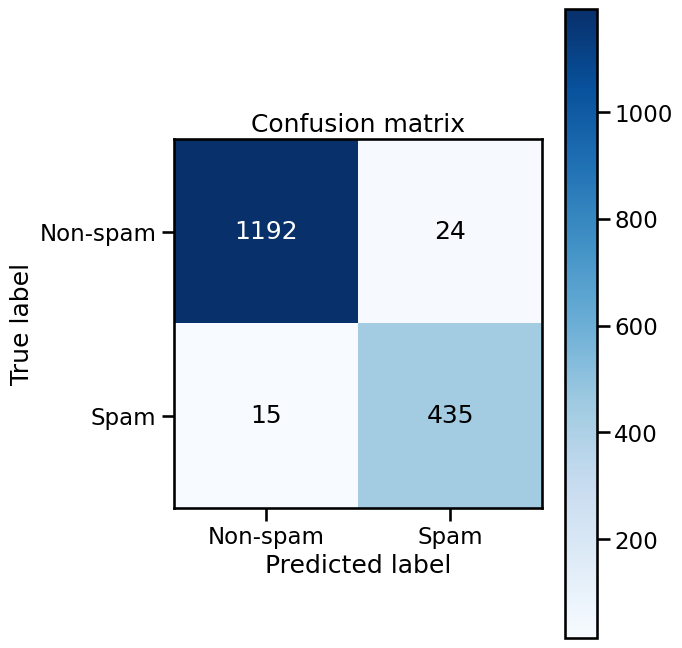

In [15]:
# Train/test splitting
df_train, df_test = tools.train_test_split_(df)

# Fit model on the train data
model = tools.fit_model(df_train)

# Print predictions on test set
tools.plot_confusion_matrix(df_test, model);

**Confusion matrices**  

Confusion matrices are a nice way of evaluating the performance of models for classification models. Rows correspond to the true classes and the columns to the predicted classes. Entries on the main diagonal of the confusion matrix correspond to correct predictions while the other cells tell us how many mistakes made our model ([online documentation](https://en.wikipedia.org/wiki/Confusion_matrix)).

* The first row represents non-spam mails: 1'192 were correctly classified as 'non-spam', while 24 (~1,9%) were misclassified as 'spam'.
* The second row represents spam mails: 435 were correctly classified as 'spam', while 15 (~3,3%) were misclassified as 'non-spam'.

Our model did quite well!

### What did our model learn from the data?

Our logistic regression model has learned which words are the most indicative of non-spam and which words are the most indicative of spam. The positive coefficients on the right correspond to words that, according to the model, are indicative of spam. The negative coefficients on the left correspond to words that, according to the model, are indicative of non-spam.

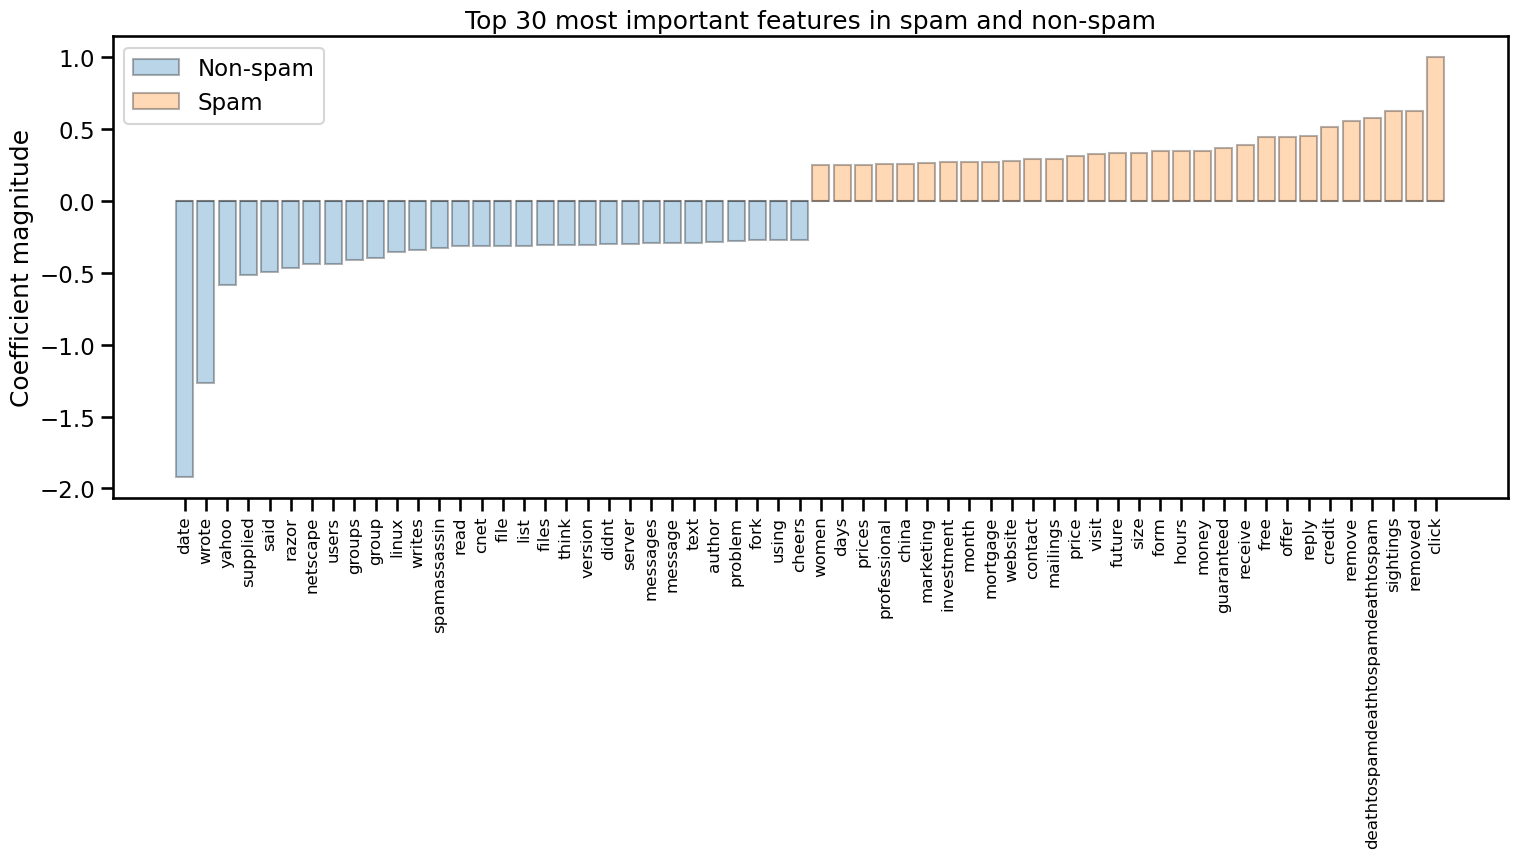

In [16]:
tools.visualize_coefficients(model, n_top_features=30)

## 💡 Observations

- According to the model, words such as "date", "wrote", "yahoo", "supplied", ... are strong indicators of non-spam.  

- Words such as "click", "removed", "sightings",  ... indicate spam.

- These results are consistent with our earlier analysis. For example we had identified "wrote", "said" and "linux" as potential indicators of non-spam ealier. Similarly "click", "credit", "free", and "money" suggested spam.

### Error analysis :: Where does our model fail?

We will now analyze the misclassified mails in order to get some insights on where the model failed to make correct predictions. The *error_analysis* function below will show us the top features responsible for the model making a decision of prediction whether the mail is spam or non-spam.

Document index: 16 


Original Text
<html><body> <center> <font face="arial"><b>Talk on Tele with locals in your area who want to meet
for real encounters. No pre recorded bull this is the real deal. <p> US residents: the 9<!--dads
tools-->00-370-54<!--starter-->65 or 8<!--ender-->88-400-1<!--end-->919. - 99<!--hi hi --> cents /
min <p> For CA callers try our special California line, California is so popular we had to create a
seperate system just for them <p> : 1-<!--moms-->9<!--low-->00-505-7575. <p> must be 18<!--none-->+
be careful when making sexual dates and meetings. Cali 9<!--polic cars-->00# is $1.99 per min
</html> 211075433222 


Cleaned text
talk tele locals area want meet real encounters recorded bull real deal residents cents callers
special california line california popular create seperate just careful making sexual dates meetings
cali 


Actual class:     Spam
Predicted class:  Non-spam 


Predicted probabilities

Non-spam:   0.5239
Spam:       0.4761



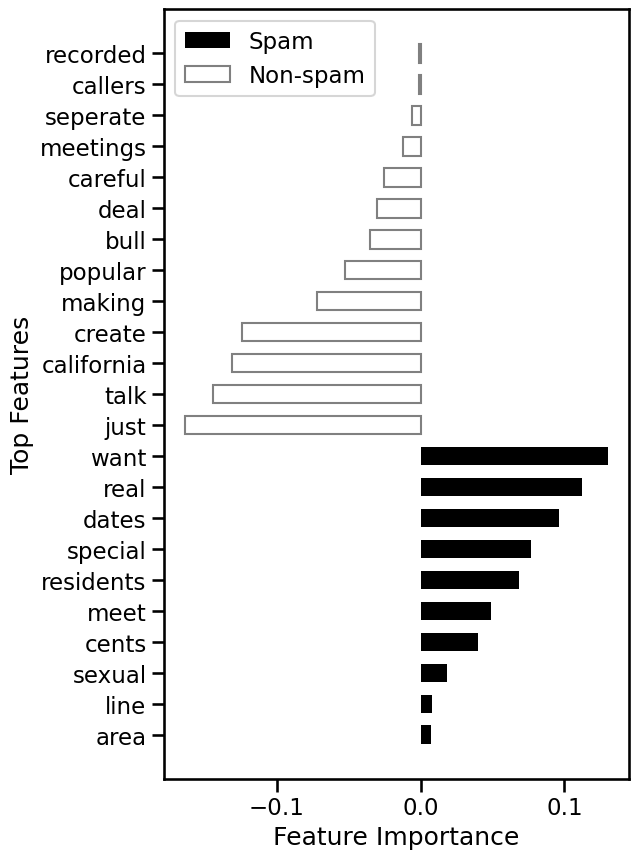

In [17]:
tools.error_analysis(df_test, model, doc_nbr=16)